# Imports

In [1]:
import sys
print(sys.executable)

c:\Users\reinm\anaconda3\envs\precursor_legacy\python.exe


Number of threads to use

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = '15' # set cores for numpy
os.environ['TF_INTER_OP_PARALLELISM_THREADS'] = '15' # set cores for TF
os.environ['TF_INTRA_OP_PARALLELISM_THREADS'] = '15'

Configure TensorFlow

In [3]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TensorFlow logs
print(tf.__version__)

2.10.0


Remaining imports

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time
from pathlib import Path

# Data Handling

Data loading

In [5]:
# Data is generated from Gen_data.ipynb. 
# ATTENTION: Get the data from Teams! File is too large to upload to GitHub
fln = "Generated_data.h5"
hf  = h5py.File(fln,'r')

# Check the contents of the HDF5 file
print("Contents of the HDF5 file:", list(hf.keys()))

Contents of the HDF5 file: ['dissipation_rates', 'kinetic_energy', 'velocity_field']


Initializing the velocity field 

In [6]:
downsample = 1 # Skip every n-th sample to get varying data. Otherwise the data is to similar and large. Set to 1 to use all data.
Re = 30
data_len = 6000
transient = 200 # Number of transient steps to ignore from our data

# Load the velocity field
U = np.array(hf.get('velocity_field')[transient:transient+data_len:downsample], dtype=np.float32)
total_samples = U.shape[0]
hf.close()

# Check the length of the velocity field
print("Shape of the velocity field:", U.shape)  
print(f"So, the velocity field has {total_samples} samples, each sample has 48x48 grid points and each grid point has 2 components (ux,uy)")

# Define the number of grid points in x and y directions
N_x     = U.shape[1] 
N_y     = U.shape[2]

Shape of the velocity field: (6000, 48, 48, 2)
So, the velocity field has 6000 samples, each sample has 48x48 grid points and each grid point has 2 components (ux,uy)


Splitting the data into train, validation and test sets, and batching the data

In [7]:
b_size = 50   #batch_size
n_batches = total_samples//b_size  #number of batches

# Split the data into training, validation and test sets with 70%, 15% and 15% of the data respectively
train_batches = int(n_batches*(7/10))
val_batches = int(n_batches*(15/100))
test_batches = int(n_batches*(15/100))

In [8]:
def batch_data(U, b_size, n_batches):
    
    '''
    Splits the data in batches. Each batch is created by sampling the signal with interval
    equal to n_batches
    '''
    data = np.zeros((n_batches, b_size, U.shape[1], U.shape[2], U.shape[3]))    
    for i in range(n_batches):
        data[i] = U[i::n_batches].copy()

    return data

In [9]:
# training data
U_train_unbatched = np.array(U[:train_batches*b_size].copy())
print("Shape of the training data before batching:", U_train_unbatched.shape)
U_train = batch_data(U_train_unbatched, b_size, train_batches).astype('float32') # to be used for randomly shuffled batches
print("Shape of the training data after batching:", U_train.shape, "\n")

# validation data
U_val_unbatched = np.array(U[train_batches*b_size:train_batches*b_size+b_size*val_batches].copy())
print("Shape of the validation data before batching:", U_val_unbatched.shape)
U_val = batch_data(U_val_unbatched, b_size, val_batches).astype('float32')         
print("Shape of the validation data after batching:", U_val.shape, "\n")

# test data
U_test_unbatched = np.array(U[train_batches*b_size+b_size*val_batches:].copy())
print("Shape of the test data before batching:", U_test_unbatched.shape)
U_test = batch_data(U_test_unbatched, b_size, test_batches).astype('float32')
print("Shape of the test data after batching:", U_test.shape)

# Delete the original data to save memory:
del U_train_unbatched, U_val_unbatched

Shape of the training data before batching: (4200, 48, 48, 2)
Shape of the training data after batching: (84, 50, 48, 48, 2) 

Shape of the validation data before batching: (900, 48, 48, 2)
Shape of the validation data after batching: (18, 50, 48, 48, 2) 

Shape of the test data before batching: (900, 48, 48, 2)
Shape of the test data after batching: (18, 50, 48, 48, 2)


# Autoencoder Functions

In [10]:
'''
Changes: included loss mse and optimizer as inputs to train_step
'''
#@tf.function #this creates the tf graph
def model(inputs, enc_mods, dec_mods, is_train=False):
    
    '''
    Multiscale autoencoder, taken from Hasegawa 2020. The contribution of the CNNs at different
    scales are simply summed.
    '''
        
    # sum of the contributions of the different CNNs
    encoded = 0
    for enc_mod in enc_mods:
        encoded += enc_mod(inputs, training=is_train)
            
    decoded = 0
    for dec_mod in dec_mods:
        decoded += dec_mod(encoded, training=is_train)
        
    return encoded, decoded


#@tf.function #this creates the tf graph
def train_step(inputs, enc_mods, dec_mods, Loss_Mse, optimizer, train=True):
    
    """
    Trains the model by minimizing the loss between input and output
    """
    
    # autoencoded field
    decoded  = model(inputs, enc_mods, dec_mods, is_train=train)[-1]

    # loss with respect to the data
    loss = Loss_Mse(inputs, decoded)
    
    # compute and apply gradients inside tf.function environment for computational efficiency
    if train:
        # create a variable with all the weights to perform gradient descent on
        # appending lists is done by plus sign
        varss = [] #+ Dense.trainable_weights
        for enc_mod in enc_mods:
            varss  += enc_mod.trainable_weights
        for dec_mod in dec_mods:
            varss +=  dec_mod.trainable_weights
        
        with tf.GradientTape() as tape:
            decoded  = model(inputs, enc_mods, dec_mods, is_train=train)[-1]
            loss = Loss_Mse(inputs, decoded)
        grads = tape.gradient(loss, varss)
        optimizer.apply_gradients(zip(grads, varss))
    
    return loss


In [11]:
def periodic_padding(image, padding=1, asym=False):
    '''
    Create a periodic padding (same of np.pad('wrap')) around the image, 
    to mimic periodic boundary conditions.
    When asym=True on the right and lower edges an additional column/row is added
    '''
        
    if asym:
        lower_pad = image[:,:padding+1,:]
    else:
        lower_pad = image[:,:padding,:]
    
    if padding != 0:
        upper_pad     = image[:,-padding:,:]
        partial_image = tf.concat([upper_pad, image, lower_pad], axis=1)
    else:
        partial_image = tf.concat([image, lower_pad], axis=1)
        
    if asym:
        right_pad = partial_image[:,:,:padding+1] 
    else:
        right_pad = partial_image[:,:,:padding]
    
    if padding != 0:
        left_pad = partial_image[:,:,-padding:]
        padded_image = tf.concat([left_pad, partial_image, right_pad], axis=2)
    else:
        padded_image = tf.concat([partial_image, right_pad], axis=2)

    return padded_image

In [12]:
class PerPad2D(tf.keras.layers.Layer):
    """
    Periodic Padding layer
    """
    def __init__(self, padding=1, asym=False, **kwargs):
        self.padding = padding
        self.asym    = asym
        super(PerPad2D, self).__init__(**kwargs)
        
    def get_config(self): #needed to be able to save and load the model with this layer
        config = super(PerPad2D, self).get_config()
        config.update({
            'padding': self.padding,
            'asym': self.asym,
        })
        return config

    def call(self, x):
        return periodic_padding(x, self.padding, self.asym)

# Create the Model

In [13]:
'''
TODO: hyperparameter tuning
'''

## define the model
# we do not have pooling and upsampling, instead we use stride=2
N_lat         = 5                          # change N_lat hyperparameter
last_conv_dep = 1                          #output depth of last conv layer, if we want to include dissipation rate and vorticity, increase this number
n_fil         = [6,12,24,last_conv_dep]          #number of filters encoder
n_dec         = [24,12,6,3]                #number of filters decoder
N_parallel    = 3                          #number of parallel CNNs for multiscale
ker_size      = [(3,3), (5,5), (7,7)]      #kernel sizes
N_layers      = 4                          #number of layers in every CNN
act           = 'tanh'                     #activation function

pad_enc       = 'valid'         #no padding in the conv layer
pad_dec       = 'valid'
p_size        = [0,1,2]         #stride = 2 periodic padding size          
p_fin         = [1,2,3]         #stride = 1 periodic padding size
p_dec         = 1               #padding in the first decoder layer
p_crop        = U.shape[1]      #crop size of the output equal to input size


In [14]:
#initialize the encoders and decoders with different kernel sizes    
enc_mods      = [None]*(N_parallel)
dec_mods      = [None]*(N_parallel)    
for i in range(N_parallel):
    enc_mods[i] = tf.keras.Sequential(name='Enc_' + str(i))
    dec_mods[i] = tf.keras.Sequential(name='Dec_' + str(i))

In [15]:
#generate encoder layers    
for j in range(N_parallel):
    for i in range(N_layers):      

        #stride=2 padding and conv
        enc_mods[j].add(PerPad2D(padding=p_size[j], asym=True,
                                          name='Enc_' + str(j)+'_PerPad_'+str(i)))
        enc_mods[j].add(tf.keras.layers.Conv2D(filters = n_fil[i], kernel_size=ker_size[j],
                                      activation=act, padding=pad_enc, strides=2,
                        name='Enc_' + str(j)+'_ConvLayer_'+str(i)))

        #stride=1 padding and conv
        if i<N_layers-1:
            enc_mods[j].add(PerPad2D(padding=p_fin[j], asym=False,
                                                      name='Enc_'+str(j)+'_Add_PerPad1_'+str(i)))
            enc_mods[j].add(tf.keras.layers.Conv2D(filters=n_fil[i],
                                                    kernel_size=ker_size[j], 
                                                activation=act,padding=pad_dec,strides=1,
                                                    name='Enc_'+str(j)+'_Add_Layer1_'+str(i)))  
    # Add fully connected layer
    enc_mods[j].add(tf.keras.layers.Flatten(name='Enc_' + str(j) + '_Flatten'))
    enc_mods[j].add(tf.keras.layers.Dense(N_lat, activation='linear', name='Enc_' + str(j) + '_Dense'))

In [16]:
#explicitly obtain the size of the latent space
output = U_train[0]
for i, layer in enumerate(enc_mods[-1].layers):
    output = layer(output)  # Forward pass through the current layer
    if i == (N_layers - 1) * 4 + 1:  # Stop after the 4th layer (index 3)
        conv_out_shape = output.shape[1:]
        conv_out_size = np.prod(conv_out_shape)
        print("Output shape of the last convolutional layer:", conv_out_shape)
        print("SIze of last convolutional output: ", conv_out_size)
    elif i == (N_layers - 1) * 4 + 2 + 1:
         print("Size of the latent space:", output.shape[-1])  

Output shape of the last convolutional layer: (3, 3, 1)
SIze of last convolutional output:  9
Size of the latent space: 5


In [17]:
_#generate decoder layers            
for j in range(N_parallel):
    
    # Add fully connected layer first to map latent space to the appropriate dimensions
    dec_mods[j].add(tf.keras.layers.Dense(conv_out_size, activation='linear', name='Dec_' + str(j) + '_Dense'))
    dec_mods[j].add(tf.keras.layers.Reshape(conv_out_shape, name='Dec_' + str(j) + '_Reshape'))


    for i in range(N_layers):

        #initial padding of latent space
        if i==0: 
            dec_mods[j].add(PerPad2D(padding=p_dec, asym=False,
                                          name='Dec_' + str(j)+'_PerPad_'+str(i))) 
        
        #Transpose convolution with stride = 2 
        dec_mods[j].add(tf.keras.layers.Conv2DTranspose(filters = n_dec[i],
                                       output_padding=None,kernel_size=ker_size[j],
                                      activation=act, padding=pad_dec, strides=2,
                            name='Dec_' + str(j)+'_ConvLayer_'+str(i)))
        
        #Convolution with stride=1
        if  i<N_layers-1:       
            dec_mods[j].add(tf.keras.layers.Conv2D(filters=n_dec[i],
                                        kernel_size=ker_size[j], 
                                       activation=act,padding=pad_dec,strides=1,
                                      name='Dec_' + str(j)+'_ConvLayer1_'+str(i)))

    #crop and final linear convolution with stride=1
    dec_mods[j].add(tf.keras.layers.CenterCrop(p_crop + 2*p_fin[j],
                                                   p_crop+ 2*p_fin[j],
                            name='Dec_' + str(j)+'_Crop_'+str(i)))
    dec_mods[j].add(tf.keras.layers.Conv2D(filters=U.shape[3],
                                            kernel_size=ker_size[j], 
                                            activation='linear',padding=pad_dec,strides=1,
                                              name='Dec_' + str(j)+'_Final_Layer'))

In [18]:
# run the model once to print summary
enc0, dec0 = model(U_train[0], enc_mods, dec_mods)
print('latent space size:', N_lat)
print('physical space size:', U[0].flatten().shape)
print('')
for j in range(3):
    enc_mods[j].summary()
for j in range(3):
    dec_mods[j].summary()

latent space size: 5
physical space size: (4608,)

Model: "Enc_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Enc_0_PerPad_0 (PerPad2D)   (50, 49, 49, 2)           0         
                                                                 
 Enc_0_ConvLayer_0 (Conv2D)  (50, 24, 24, 6)           114       
                                                                 
 Enc_0_Add_PerPad1_0 (PerPad  (50, 26, 26, 6)          0         
 2D)                                                             
                                                                 
 Enc_0_Add_Layer1_0 (Conv2D)  (50, 24, 24, 6)          330       
                                                                 
 Enc_0_PerPad_1 (PerPad2D)   (50, 25, 25, 6)           0         
                                                                 
 Enc_0_ConvLayer_1 (Conv2D)  (50, 12, 12, 12)          660       
          

# Train the Model

In [28]:
n_epochs = 5
rng = np.random.default_rng() # random generator for later shuffling

#define loss, optimizer and initial learning rate   
Loss_Mse    = tf.keras.losses.MeanSquaredError()
optimizer   = tf.keras.optimizers.Adam(amsgrad=True) #amsgrad True for better convergence
l_rate      = 0.002
optimizer.learning_rate = l_rate

# Add dropout layers to the encoder and decoder models
dropout_rate = 0.5  # You can adjust this rate

for enc_mod in enc_mods:
    for layer in enc_mod.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            enc_mod.add(tf.keras.layers.Dropout(dropout_rate))

for dec_mod in dec_mods:
    for layer in dec_mod.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Conv2DTranspose):
            dec_mod.add(tf.keras.layers.Dropout(dropout_rate))

# quantities to check and store the training and validation loss and the training goes on
tloss_plot    = np.zeros(n_epochs)      # training loss
vloss_plot    = np.zeros(n_epochs)      # validation loss
N_check       = 1                       # each N_check epochs we check convergence and validation loss
patience      = 2                       # if the val_loss has not gone down in the last patience epochs, early stop
last_save     = patience               # last epoch where the model was saved

In [29]:
t = time.time()  # Initialize time for printing time per epoch 

for epoch in range(n_epochs):
    
    # Incorporate early stopping
    if epoch - last_save > patience:
        print('Early stopping')
        break
                
    # Perform gradient descent for all the batches every epoch
    loss_0 = 0
    rng.shuffle(U_train, axis=0) # shuffle batches
    for j in range(train_batches):
        loss    = train_step(U_train[j], enc_mods, dec_mods, Loss_Mse, optimizer)
        loss_0 += loss
    
    # save train loss
    tloss_plot[epoch]  = loss_0.numpy()/train_batches
    
    # every N epochs checks the convergence of the training loss and val loss
    if (epoch%N_check==0):
        
        # Compute Validation Loss
        loss_val        = 0
        for j in range(val_batches):
            loss        = train_step(U_val[j], enc_mods, dec_mods, Loss_Mse, optimizer, train=False)
            loss_val   += loss
        
        # Save validation loss
        vloss_plot[epoch]  = loss_val.numpy()/val_batches 
        
        # # Records the epoch of the best model (the one with minimum validation loss) for early stopping
        # min_vloss_epoch = np.argmin(vloss_plot[:epoch+1])
        # print('Minimum vloss epoch:', min_vloss_epoch)
        # #(vloss_plot[:epoch-1][np.nonzero(vloss_plot[:epoch-1])]).min() # Extracts the non-zero validation losses and finds the minimum value among them
        # if epoch > 1 and vloss_plot[epoch] < min_vloss_epoch:
        #     last_save = epoch # store the last time the val loss has decreased for early stop
        # print('last save:', last_save)

        # Print loss values and training time (per epoch)
        print('Epoch', epoch, '; Train_Loss', f"{tloss_plot[epoch]:.4f}", 
              '; Val_Loss', f"{vloss_plot[epoch]:.4f}",  '; Ratio', f"{(vloss_plot[epoch])/(tloss_plot[epoch]):.4f}")
        print(f'Time per epoch {(time.time()-t):.2f} seconds')
        print('')
        t = time.time()  # Reset time after each epoch

#saving the model weights
print('Saving Model..')
model_path = './data/48_RE30_'+str(N_lat) # to save model
Path(model_path).mkdir(parents=True, exist_ok=True) #creates directory even when it exists
for i in range(N_parallel):
    enc_mods[i].save(model_path + '/enc_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5')
    dec_mods[i].save(model_path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5')
    enc_mods[i].save_weights(model_path + '/enc_mod'+str(ker_size[i])+'_'+str(N_lat)+'_weights.h5')
    dec_mods[i].save_weights(model_path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'_weights.h5')

print('Model saved')

Epoch 0 ; Train_Loss 2.2851 ; Val_Loss 0.6760 ; Ratio 0.2958
Time per epoch 316.92 seconds

Epoch 1 ; Train_Loss 0.7526 ; Val_Loss 0.6610 ; Ratio 0.8784
Time per epoch 307.45 seconds

Epoch 2 ; Train_Loss 0.7259 ; Val_Loss 0.6595 ; Ratio 0.9085
Time per epoch 352.31 seconds

Epoch 3 ; Train_Loss 0.7132 ; Val_Loss 0.6608 ; Ratio 0.9266
Time per epoch 468.35 seconds

Epoch 4 ; Train_Loss 0.7073 ; Val_Loss 0.6677 ; Ratio 0.9440
Time per epoch 277.79 seconds

Saving Model..
Model saved


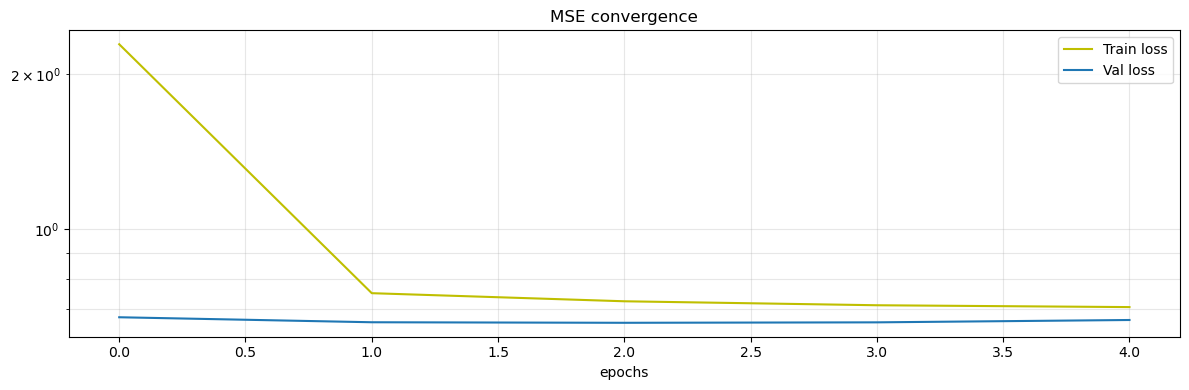

Plotting done


In [30]:
# Set smaller figure size
plt.figure(figsize=(12, 4))  # Width = 6 inches, Height = 4 inches

plt.title('MSE convergence')
plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.plot(tloss_plot[np.nonzero(tloss_plot)], 'y', label='Train loss')
plt.plot(np.arange(np.nonzero(vloss_plot)[0].shape[0]) * N_check, vloss_plot[np.nonzero(vloss_plot)], label='Val loss')
plt.xlabel('epochs')
plt.legend()    
plt.tight_layout()
plt.show()

print("Plotting done")

# Compute the error over the test set

In [32]:
# Compute the NRMSE for the test data by comparing the encoded data and the ground truth data
numerator = 0
denominator = 0

print(U_test.shape)

for i in range(test_batches):
    decoded = model(U_test[i], enc_mods, dec_mods)[-1].numpy()

    batch_test = U_test[i].copy()
    batch_test = batch_test.reshape(50,48*48*2)

    dec_test = decoded.copy()
    dec_test = dec_test.reshape(50,48*48*2)
    denominator += np.sum(np.std(batch_test, axis=1))
    
    loss = Loss_Mse(batch_test, dec_test)
    numerator += loss.numpy()

NRMSE = np.sqrt(numerator/denominator)
print("NRMSE:", NRMSE)

(18, 50, 48, 48, 2)
NRMSE: 0.12841650942943103


# Visualize error

In [33]:
#load model for the test set
path = './data/48_RE30_'+str(N_lat)
os.makedirs(path, exist_ok=True)

enc_mods_test = [None] * N_parallel
dec_mods_test = [None] * N_parallel

for i in range(N_parallel):
    enc_path = f"{path}/enc_mod{ker_size[i]}_{N_lat}.h5"
    dec_path = f"{path}/dec_mod{ker_size[i]}_{N_lat}.h5"
    print(f"Loading models: encoder -> {enc_path}, decoder -> {dec_path}")

    if os.path.exists(enc_path) and os.path.exists(dec_path):
        try:
            enc_mods_test[i] = tf.keras.models.load_model(enc_path, custom_objects={"PerPad2D": PerPad2D})
            dec_mods_test[i] = tf.keras.models.load_model(dec_path, custom_objects={"PerPad2D": PerPad2D})
        except Exception as e:
            raise RuntimeError(f"Error loading models: {e}")
    else:
        raise FileNotFoundError(f"Model files not found: {enc_path}, {dec_path}")


Loading models: encoder -> ./data/48_RE30_5/enc_mod(3, 3)_5.h5, decoder -> ./data/48_RE30_5/dec_mod(3, 3)_5.h5
Loading models: encoder -> ./data/48_RE30_5/enc_mod(5, 5)_5.h5, decoder -> ./data/48_RE30_5/dec_mod(5, 5)_5.h5
Loading models: encoder -> ./data/48_RE30_5/enc_mod(7, 7)_5.h5, decoder -> ./data/48_RE30_5/dec_mod(7, 7)_5.h5


0


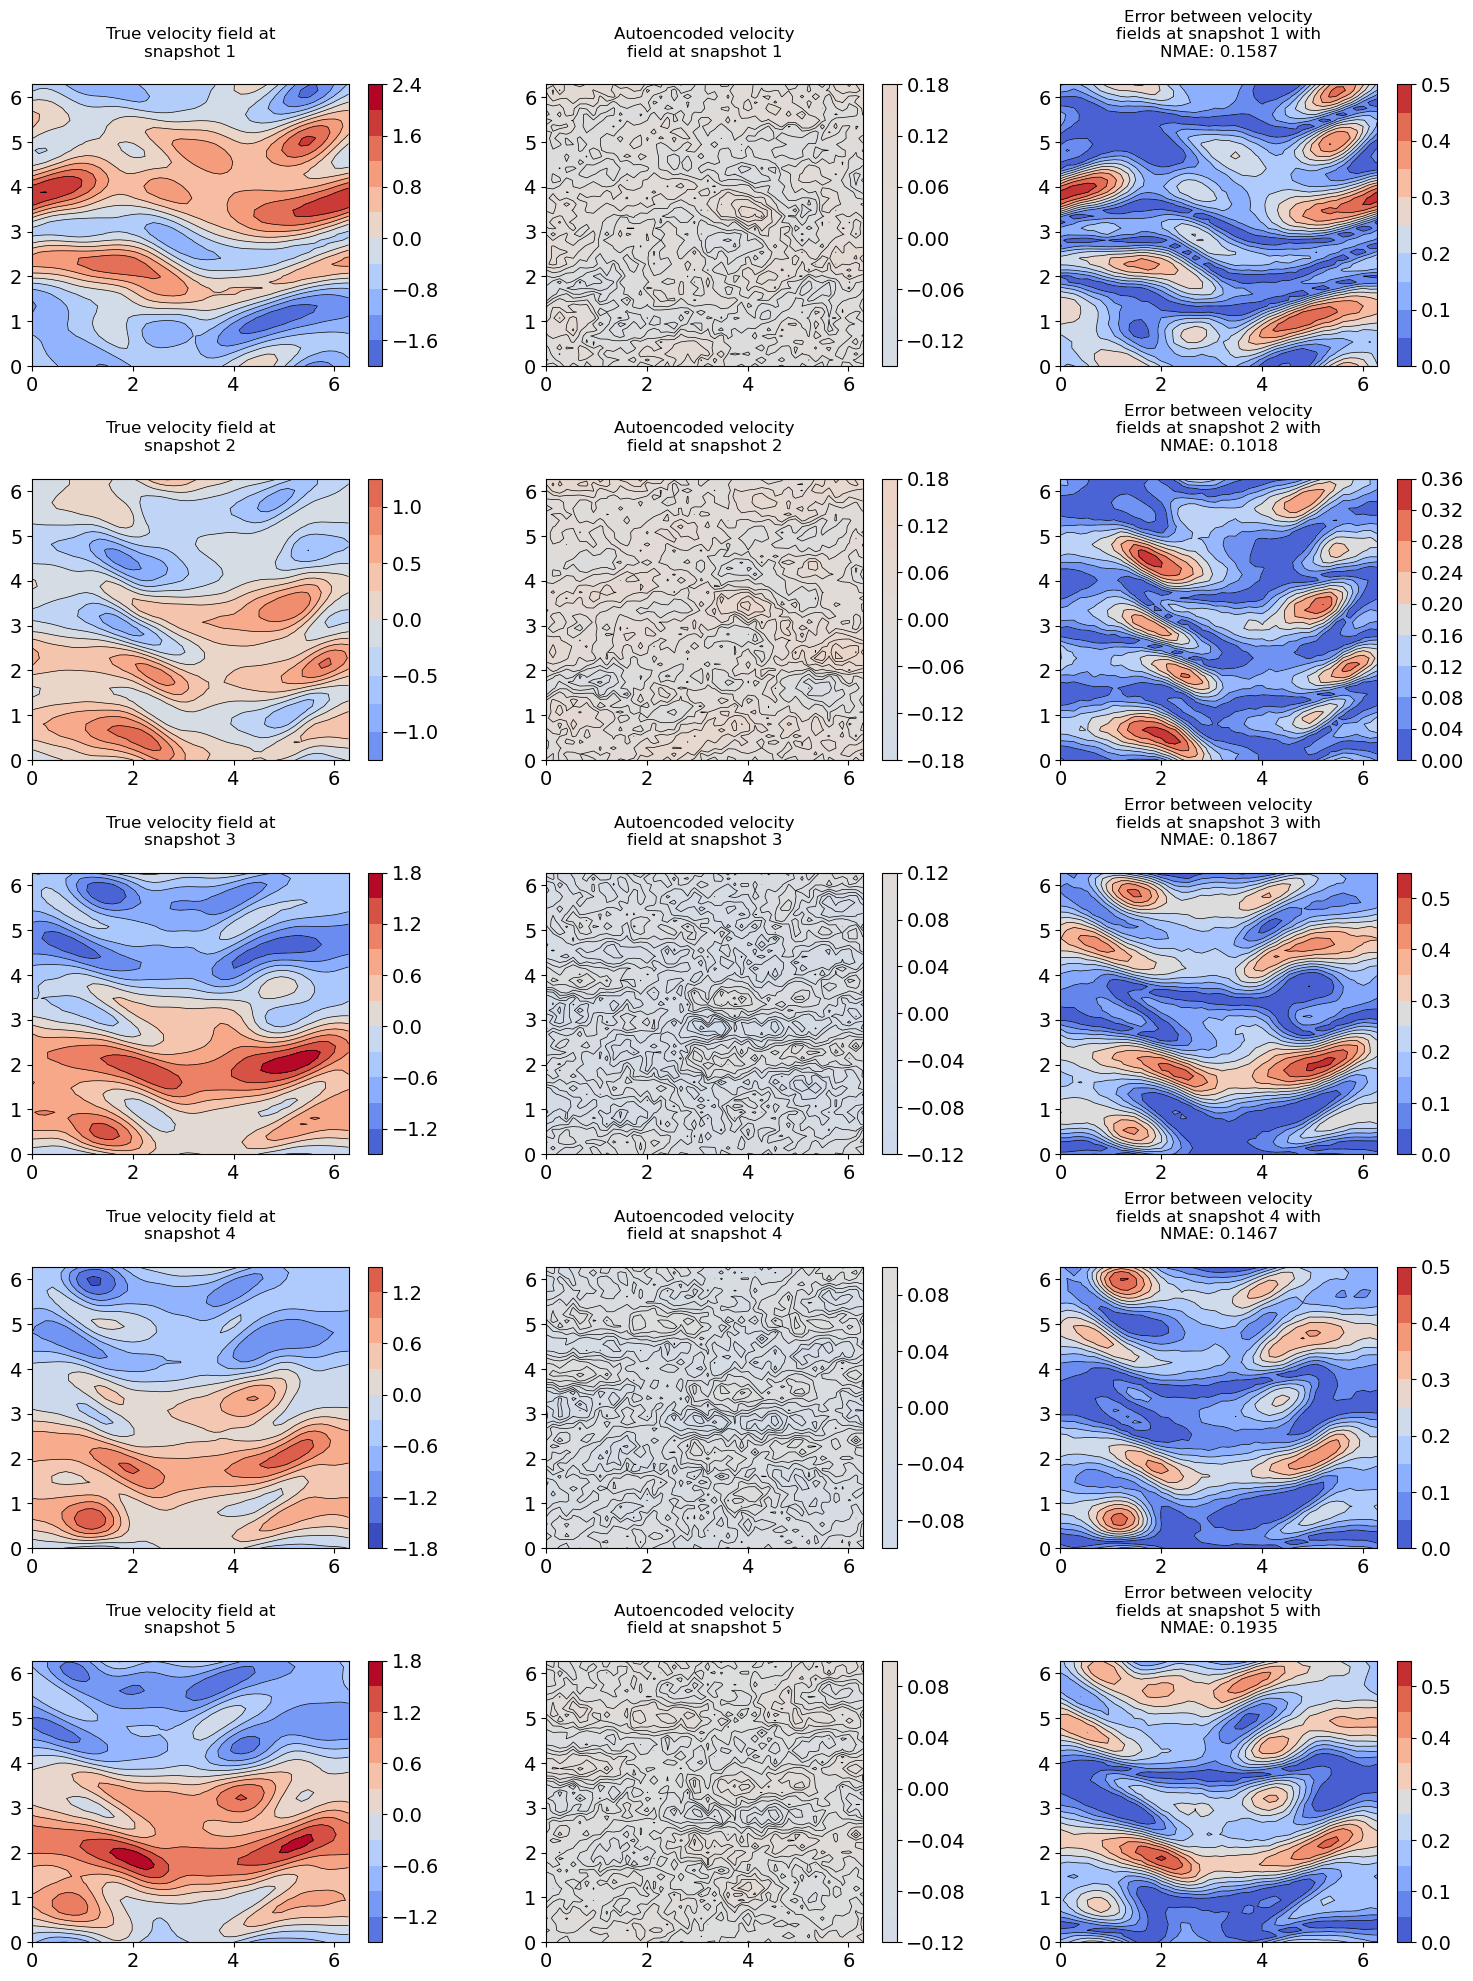

In [34]:
import textwrap

# grid
X = np.linspace(0, 2 * np.pi, N_x) 
Y = np.linspace(0, 2 * np.pi, N_y) 
XX = np.meshgrid(X, Y, indexing='ij')

# plot n snapshots and their reconstruction in the test set.
n_snapshots = 5
plt.rcParams["figure.figsize"] = (15, 4 * n_snapshots)
plt.rcParams["font.size"] = 14
fig, ax = plt.subplots(n_snapshots, 3)

# start after validation set
start = 0 # b_size * n_batches * downsample + b_size * val_batches * downsample
print(start)

# Function to wrap text
def wrap_text(text, width=25):
    return "\n".join(textwrap.wrap(text, width))

for i in range(n_snapshots):
    # testing data
    skips = 100
    # u = U_test_unbatched[i*100:i*100+1].copy()
    u      = U_test_unbatched[start+10+i*skips:start+11+i*skips].copy() 
    vmax = u.max()
    vmin = u.min()
    
    # truth
    ax_truth = plt.subplot(n_snapshots, 3, i * 3 + 1)
    CS0 = ax_truth.contourf(XX[0], XX[1], u[0, :, :, 0],
                            levels=10, cmap='coolwarm', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(CS0, ax=ax_truth)
    CS = ax_truth.contour(XX[0], XX[1], u[0, :, :, 0],
                          levels=10, colors='black', linewidths=.5, linestyles='solid',
                          vmin=vmin, vmax=vmax)
    title = wrap_text(f'True velocity field at snapshot {i+1}')
    ax_truth.set_title(title, pad=20, fontsize=12)

    # autoencoded
    ax_auto = plt.subplot(n_snapshots, 3, i * 3 + 2)
    u_dec = model(u, enc_mods_test, dec_mods_test)[1][0].numpy()
    CS = ax_auto.contourf(XX[0], XX[1], u_dec[:, :, 0],
                          levels=10, cmap='coolwarm', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(CS, ax=ax_auto)
    CS = ax_auto.contour(XX[0], XX[1], u_dec[:, :, 0],
                         levels=10, colors='black', linewidths=.5, linestyles='solid',
                         vmin=vmin, vmax=vmax)
    title = wrap_text(f'Autoencoded velocity field at snapshot {i+1}')
    ax_auto.set_title(title, pad=20, fontsize=12)
    
    # error
    ax_err = plt.subplot(n_snapshots, 3, i * 3 + 3)
    u_err = np.abs(u_dec - u[0]) / (vmax - vmin)
    nmae = u_err[:, :, 0].mean()

    CS = ax_err.contourf(XX[0], XX[1], u_err[:, :, 0], levels=10, cmap='coolwarm')
    cbar = plt.colorbar(CS, ax=ax_err)
    CS = ax_err.contour(XX[0], XX[1], u_err[:, :, 0], levels=10, colors='black', linewidths=.5,
                        linestyles='solid')
    title = wrap_text(f'Error between velocity fields at snapshot {i+1} with NMAE: {nmae:.4f}')
    ax_err.set_title(title, pad=20, fontsize=12)
    
# Adjust spacing between plots
fig.tight_layout(pad=1.0)  # Increase the padding between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Add extra spacing between rows and columns

plt.savefig(path + '/Autoencoder_error.pdf')
plt.show()

# Save Encoded Data

In [ ]:
a = [None]*N_parallel
b = [None]*N_parallel

for i in range(N_parallel):
    a[i] = tf.keras.models.load_model(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5', 
                                            custom_objects={"PerPad2D": PerPad2D})
    
for i in range(N_parallel):
    b[i] = tf.keras.models.load_model(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5', 
                                            custom_objects={"PerPad2D": PerPad2D})

U_enc = np.zeros((500, N_lat))

for i in range(500):
    U_enc[i] = model(U[i:i+1], a, b)[0].numpy().flatten()

fln = './data/48_Encoded_data_Re30_' + str(N_lat) +'.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('U_enc'      ,data=U_enc)  
hf.close()
print(fln)

./data/48_Encoded_data_Re30_5.h5


# Decoder

In [26]:
def batch_encoded(U_enc, b_size, n_batches):
    data = np.zeros((n_batches, b_size, U_enc.shape[1]))    
    for i in range(n_batches):
        data[i] = U_enc[i*b_size: (i+1)*b_size].copy()
    return data

In [27]:
U_enct = np.array(U_enc.copy())

batch_size = 10

n_batch = len(U_enc) // batch_size
U_enc_test = batch_encoded(U_enct, batch_size, n_batch)

In [28]:
def dec_model(encoded, dec_mods):
    
    '''
    This is only the decoder module
    '''
        
    decoded = 0
    for dec_mod in dec_mods:
        decoded += dec_mod(encoded, training=False)
        
    return decoded

In [29]:
load_decs = [None]*N_parallel

for i in range(N_parallel):
    load_decs[i] = tf.keras.models.load_model(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_lat)+'.h5', 
                                            custom_objects={"PerPad2D": PerPad2D})

U_dec = np.zeros((n_batch, batch_size, 48, 48, 2))

for i, batch in enumerate(U_enc_test):
    U_dec[i] = dec_model(batch, load_decs)

dec_file = './data/48_Decoded_data_Re30_' + str(N_lat) +'.h5'
hf = h5py.File(dec_file,'w')
hf.create_dataset('U_dec',data=U_dec)  
hf.close()
print(dec_file)

./data/48_Decoded_data_Re30_5.h5
